In [15]:
# setup chunk

## import libraries
import torch
import torch.nn as nn
import os
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import random
import math

## set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Importing the CNN Model
We begin by importing the CNN model that we previously configured and trained using the MS COCO and Oxford Street datasets. To achieve this, we need to redefine the same model architecture. Once the architecture is set, we can then load the corresponding model weights.

In [16]:
# Basic block with two convolutional layers
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Overall CNN model architecture
class CNN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNN, self).__init__()
        self.in_channels = 32

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        # Stacked layers of basic block with increasing number of filters
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        # Average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

cnn_model = CNN(BasicBlock, [3, 4, 6, 3]).to(device)
model_weights_path = "/kaggle/input/deeplearningproject/data_analysis/data_analysis/cnn_model_weights.pth"
cnn_model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device)))

<All keys matched successfully>

### Testing Model on Earthcam Images
Next, we apply the CNN model to the Earthcam images we collected for London, New York and New Orleans. After defining the folder paths where the surveillance images are located, a preprocessing object is defined that converts the images into tensor objects and normalizes them in the same way as the training data used to train the CNN. To test the performance of the model, we visualize some example images with the corresponding predicted number of people that the model has output.

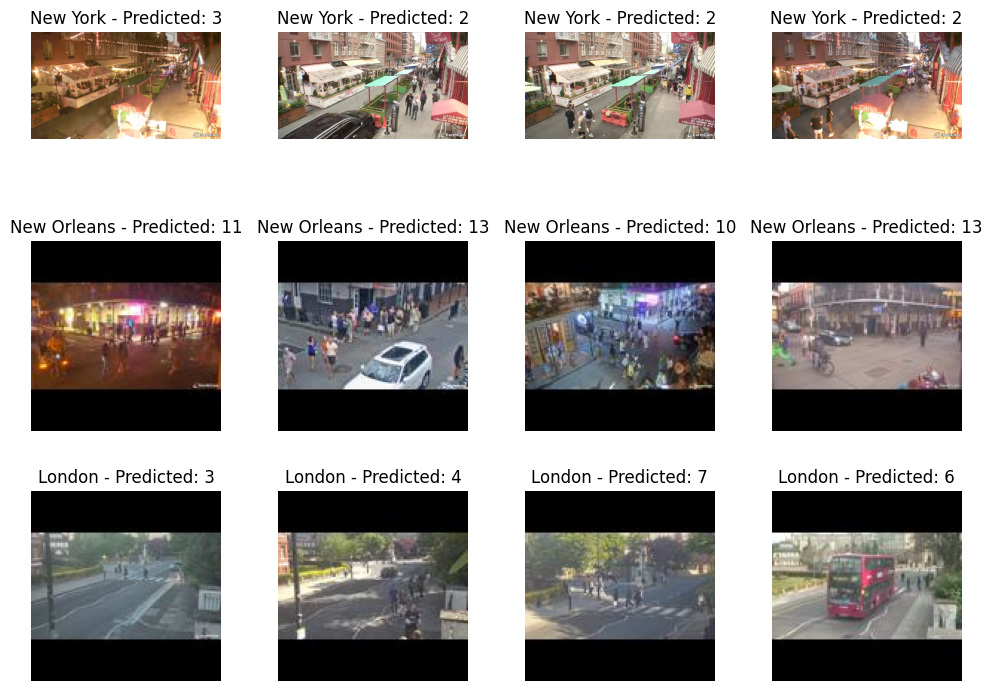

In [17]:
# Define paths to image folders
folder_paths = {
    'New York': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/Filtered_Images/NewYork_filtered',
    'New Orleans': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/Filtered_Images/NewOrleans_filtered',
    'London': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/Filtered_Images/London_filtered'
}

# Define image preprocessing steps
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# visualize how model works on the images

# visualize how model works on the images
def visualize_prediction(model, year, number_of_images_per_city=2):
    model.eval()

    all_image_files = []
    
    for city, image_dir in folder_paths.items():
        city_image_files = []
        
        for filename in os.listdir(image_dir):
            if filename.endswith(".jpg"):
                parts = filename.split('_')
                date = parts[1]
                file_year = date.split('-')[-1]
                if file_year == year:
                    city_image_files.append((city, filename))
        
        if len(city_image_files) >= number_of_images_per_city:
            # Randomly select the specified number of images for this city
            selected_images = random.sample(city_image_files, number_of_images_per_city)
            all_image_files.extend(selected_images)
        else:
            # In case there are fewer images than required, select all
            all_image_files.extend(city_image_files)

    total_images = len(all_image_files)
    rows = math.ceil(total_images / 4)
    cols = min(4, total_images)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, (city, filename) in enumerate(all_image_files):
        image_dir = folder_paths[city]
        image_path = os.path.join(image_dir, filename)
        
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        image = preprocess(image).unsqueeze(0).to(device)

        # Predict using the model
        predicted_count = model(image)
        predicted_count = torch.round(predicted_count).item()

        # Convert tensor to numpy for display
        image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

        # Determine the correct axis for single or multiple rows/columns
        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1 or cols == 1:
            ax = axes[i]
        else:
            ax = axes[i // cols, i % cols]

        # Display the image with title showing city and predicted count
        ax.imshow(image_np)
        ax.set_title(f"{city} - Predicted: {int(predicted_count)}")
        ax.axis('off')

    plt.show()

# Visualize the prediction for images from each city
visualize_prediction(cnn_model, "2022", number_of_images_per_city=4)

### Main Analysis
Now that we have seen how the CNN works in different situations, we come to the main part of the analysis. Here we predict the number of people for all the images we have collected for all three cities. Next, we take the average of the individual days per city per year. This is to model a trend of how the number of people has evolved over time. By calculating the mean value, we want to minimize the problem that the images were taken at very different times of day and do not always show exactly the same camera angle. Averaging over the number of images should therefore make our results more robust to this randomness.

In [19]:
results = {
    "London": {
        "2019": {"05-01-2019": [], "05-02-2019": [], "05-03-2019": [], "05-04-2019": [],
                 "05-05-2019": [], "05-06-2019": [], "05-07-2019": [], "05-08-2019": [],
                 "05-09-2019": [], "05-10-2019": [], "05-11-2019": [], "05-12-2019": [],
                 "05-13-2019": [], "05-14-2019": []},
        "2020": {"05-01-2020": [], "05-02-2020": [], "05-03-2020": [], "05-04-2020": [],
                 "05-05-2020": [], "05-06-2020": [], "05-07-2020": [], "05-08-2020": [],
                 "05-09-2020": [], "05-10-2020": [], "05-11-2020": [], "05-12-2020": [],
                 "05-13-2020": [], "05-14-2020": []},
        "2022": {"05-01-2022": [], "05-02-2022": [], "05-03-2022": [], "05-04-2022": [],
                 "05-05-2022": [], "05-06-2022": [], "05-07-2022": [], "05-08-2022": [],
                 "05-09-2022": [], "05-10-2022": [], "05-11-2022": [], "05-12-2022": [],
                 "05-13-2022": [], "05-14-2022": []}
    },
    "New York": {
        "2019": {"06-16-2019": [], "06-17-2019": [], "06-18-2019": [], "06-19-2019": [],
                 "06-20-2019": [], "06-21-2019": [], "06-22-2019": [], "06-23-2019": [],
                 "06-24-2019": [], "06-25-2019": [], "06-26-2019": [], "06-27-2019": [],
                 "06-28-2019": [], "06-29-2019": []},
        "2020": {"06-16-2020": [], "06-17-2020": [], "06-18-2020": [], "06-19-2020": [],
                 "06-20-2020": [], "06-21-2020": [], "06-22-2020": [], "06-23-2020": [],
                 "06-24-2020": [], "06-25-2020": [], "06-26-2020": [], "06-27-2020": [],
                 "06-28-2020": [], "06-29-2020": []},
        "2022": {"06-16-2022": [], "06-17-2022": [], "06-18-2022": [], "06-19-2022": [],
                 "06-20-2022": [], "06-21-2022": [], "06-22-2022": [], "06-23-2022": [],
                 "06-24-2022": [], "06-25-2022": [], "06-26-2022": [], "06-27-2022": [],
                 "06-28-2022": [], "06-29-2022": []}
    },
    "New Orleans": {
        "2019": {"05-13-2019": [], "05-14-2019": [], "05-15-2019": [], "05-16-2019": [],
                 "05-17-2019": [], "05-18-2019": [], "05-19-2019": [], "05-20-2019": [],
                 "05-21-2019": [], "05-22-2019": [], "05-23-2019": [], "05-24-2019": [],
                 "05-25-2019": [], "05-26-2019": []},
        "2020": {"05-13-2020": [], "05-14-2020": [], "05-15-2020": [], "05-16-2020": [],
                 "05-17-2020": [], "05-18-2020": [], "05-19-2020": [], "05-20-2020": [],
                 "05-21-2020": [], "05-22-2020": [], "05-23-2020": [], "05-24-2020": [],
                 "05-25-2020": [], "05-26-2020": []},
        "2022": {"05-13-2022": [], "05-14-2022": [], "05-15-2022": [], "05-16-2022": [],
                 "05-17-2022": [], "05-18-2022": [], "05-19-2022": [], "05-20-2022": [],
                 "05-21-2022": [], "05-22-2022": [], "05-23-2022": [], "05-24-2022": [],
                 "05-25-2022": [], "05-26-2022": []}
    }
}

def predict_image(image, model):
    model.eval()
    image = preprocess(image).unsqueeze(0).to(device) # adding extra dimension for batch size of 1
    with torch.no_grad():
        count = model(image)
        count = torch.round(count).item()
    return count

for city, path in folder_paths.items():
    
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            parts = filename.split('_')
            city_name = parts[0]
            date = parts[1]
            year = date.split('-')[-1]
            
            image_path = os.path.join(path, filename)
            image = Image.open(image_path).convert('RGB')
            count = predict_image(image, cnn_model)
            
            if year in results[city]:
                results[city][year][date].append(count)

                
averages = {}

for city, years in results.items():
    averages[city] = {}
    for year, days in years.items():
        averages[city][year] = {}
        for day, counts in days.items():      
            avg_count = sum(counts) / len(counts)
            averages[city][year][day] = avg_count

In a final step, we visualize our results in three graphs (one per city) that show the development of the average number of people counted per day. For each city, the graph shows the same two weeks in 2019, 2020 and 2022. The first week in 2020 corresponds to a period in which the city in question was in lockdown. In the second week of 2022, this lockdown was eased again. We have shaded the corresponding areas red for the lockdown and green for the period in which this lockdown has already been eased to a certain extent.

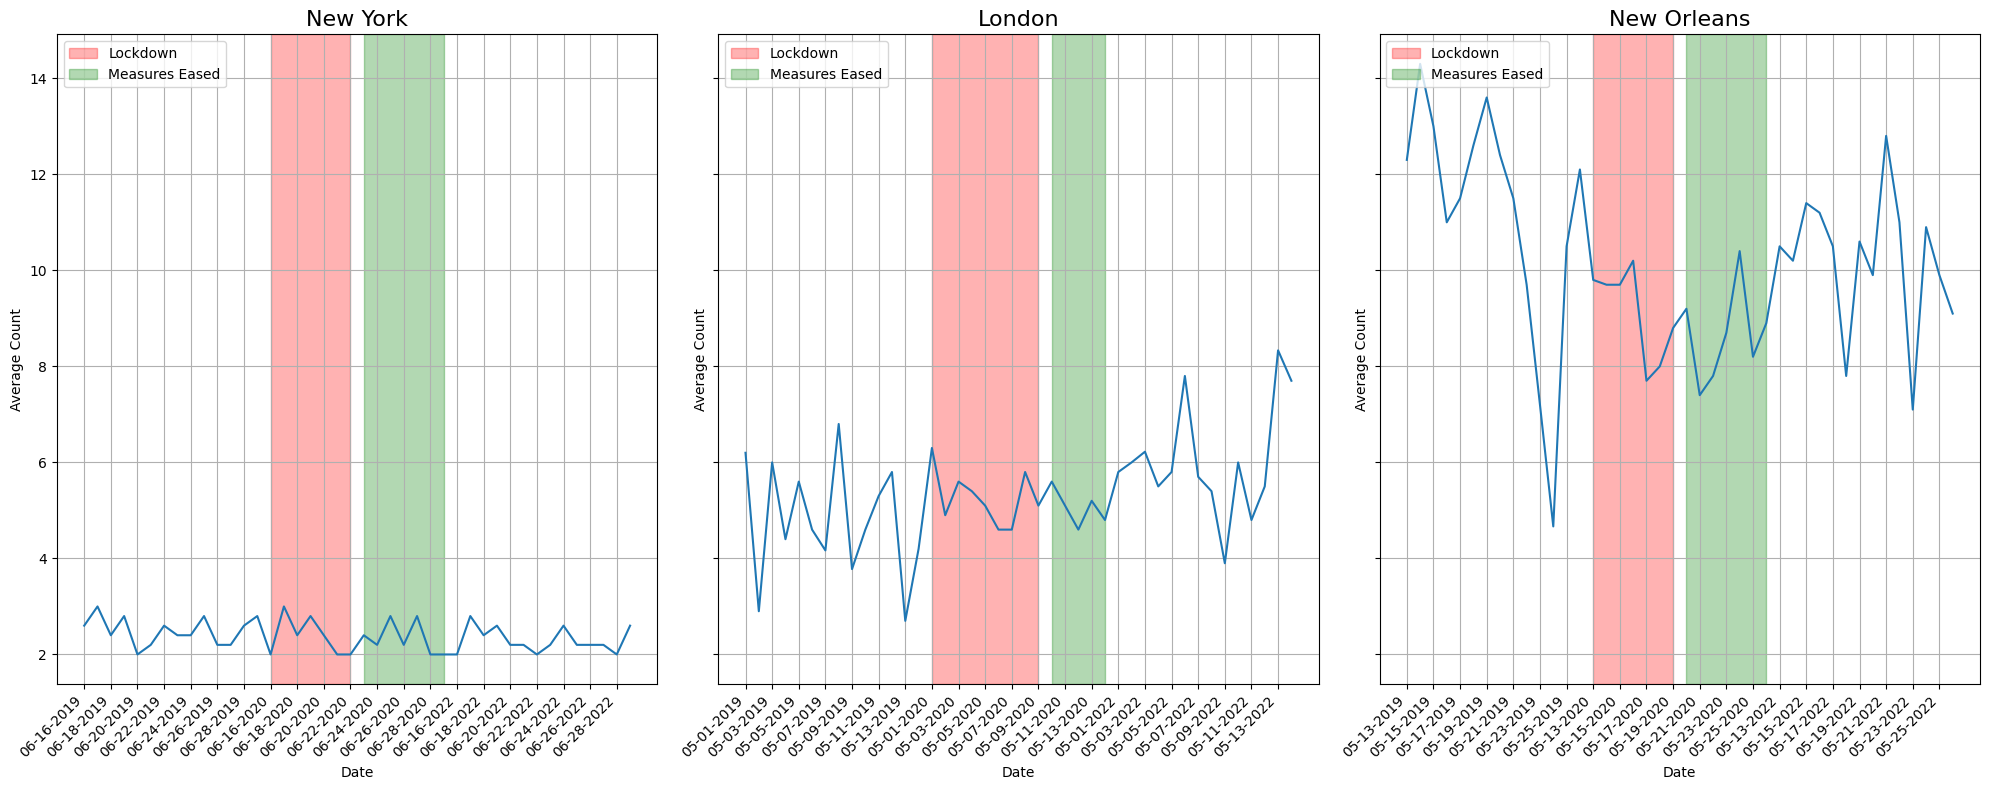

In [20]:
def flatten_averages(averages):
    flattened = []
    for city, years in averages.items():
        for year, date in years.items():
            for date, avg_count in date.items():
                flattened.append((city, date, avg_count))
    return flattened

data = flatten_averages(averages)

fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharex=False, sharey=True)

cities = ['New York', 'London', 'New Orleans']

lockdown_first_date = {"London": "05-01-2020",
                    "New York": "06-16-2020",
                    "New Orleans": "05-13-2020"}
lockdown_last_date = {"London": "05-09-2020",
                   "New York": "06-22-2020",
                   "New Orleans": "05-19-2020"}
lockdowneasing_first_date = {"London": "05-10-2020",
                           "New York": "06-23-2020",
                           "New Orleans": "05-20-2020"}
lockdowneasing_last_date = {"London": "05-14-2020",
                           "New York": "06-29-2020",
                           "New Orleans": "05-26-2020"}

for i, city in enumerate(cities):
    city_data = [(date, avg_count) for c, date, avg_count in data if c == city]
    
    if city_data:
        dates, counts = zip(*city_data)
        axs[i].plot(dates, counts)
        axs[i].set_title(f'{city}', fontsize=16)
        axs[i].set_xlabel('Date', fontsize=14)
        axs[i].set_ylabel('Average Count', fontsize=14)
        axs[i].grid(True)
        axs[i].set_xticks(dates[::len(dates)//21])
        plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axs[i].axvspan(lockdown_first_date[city], lockdown_last_date[city], color="red", alpha=0.3, label="Lockdown")
        axs[i].axvspan(lockdowneasing_first_date[city], lockdowneasing_last_date[city], color="green", alpha=0.3, label="Measures Eased")
        axs[i].legend(loc='upper left')

plt.tight_layout()
plt.show()